In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import json
import shutil
import time
import tensorflow as tf
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Flatten, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import label_binarize

In [2]:
df_business = pd.read_csv('yelp_academic_dataset_business.csv')
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
photo_path = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\photos"
photos_df = pd.read_json('photos.json', lines=True)
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [4]:
photos_df['label' ].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [5]:
df_business.shape

(150346, 14)

In [6]:
photos_df.shape

(200100, 4)

In [7]:
if 'category' in photos_df.columns:
    label_column = 'category'
elif 'label' in photos_df.columns:
    label_column = 'label'
else:
    raise ValueError("The JSON file does not contain a label column.")

C:\Users\indra\AppData\Local\Temp\ipykernel_27056\3666958647.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(label_counts))


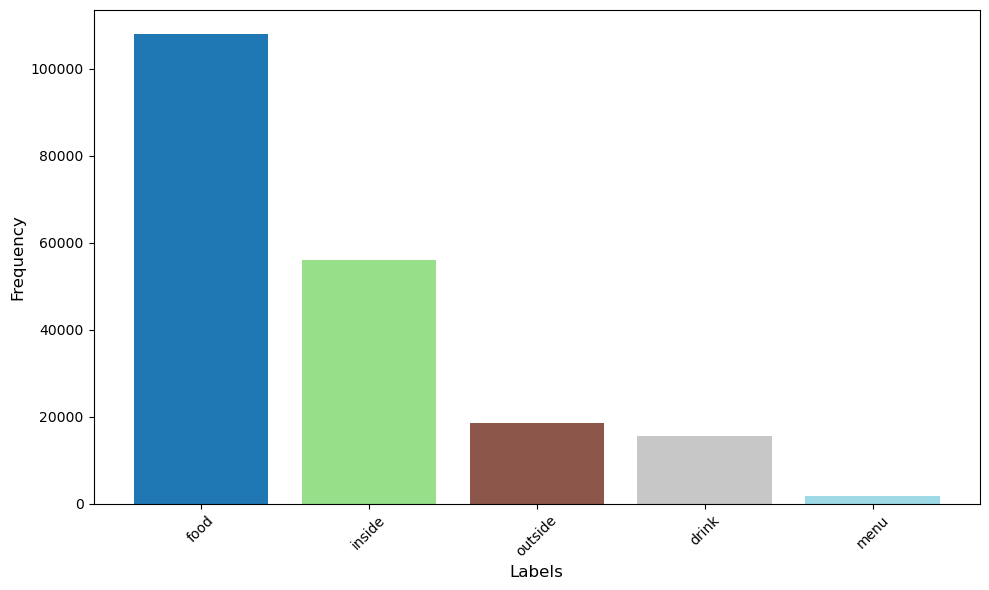

In [8]:
label_counts = photos_df[label_column].value_counts()
colors = plt.cm.get_cmap("tab20", len(label_counts))
color_list = [colors(i) for i in range(len(label_counts))]
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=color_list)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
image_dir = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\photos"

In [10]:
output_base = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\processed"

In [11]:
valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
photos_df = photos_df[photos_df['label'].isin(valid_labels)]

In [12]:
# # comment
# import os
# import pandas as pd
# import shutil
# from sklearn.model_selection import train_test_split

# # Path where images are stored
# image_dir = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\photos"

# # Output base directory
# output_base = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\processed"

# # Load your dataframe (replace with your actual CSV if needed)
# # For example: photos_df = pd.read_csv('photos.csv')
# # Assuming you've already loaded it as photos_df

# # Filter to only use the valid labels
# valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
# photos_df = photos_df[photos_df['label'].isin(valid_labels)]

# # Create train/test split per label
# for label in valid_labels:
#     label_df = photos_df[photos_df['label'] == label]
    
#     # Split into train and test
#     train_df, test_df = train_test_split(label_df, test_size=0.2, random_state=42)

#     # Create target directories
#     train_label_dir = os.path.join(output_base, 'train', label)
#     test_label_dir = os.path.join(output_base, 'test', label)
#     os.makedirs(train_label_dir, exist_ok=True)
#     os.makedirs(test_label_dir, exist_ok=True)

#     # Move train images
#     for photo_id in train_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(train_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy(src, dst)

#     # Move test images
#     for photo_id in test_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(test_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy(src, dst)

# print("✅ Image folders created and populated successfully.")

In [13]:
df = photos_df.merge(df_business[['business_id', 'categories']], on='business_id', how='left')

In [14]:
df.head()

,photo_id,business_id,caption,label,categories
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,"Restaurants, Pubs, Nightlife, American (Tradit..."
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,"Barbeque, Sandwiches, American (Traditional), ..."
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,"Live/Raw Food, Seafood, Restaurants, Cajun/Creole"
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,"Restaurants, Vegan, Food, Ice Cream & Frozen Y..."


In [15]:
df.drop(["business_id","caption"],axis=1,inplace=True)

In [16]:
df.head()

,photo_id,label,categories
0,zsvj7vloL4L5jhYyPIuVwg,inside,"Restaurants, Pubs, Nightlife, American (Tradit..."
1,HCUdRJHHm_e0OCTlZetGLg,outside,"Barbeque, Sandwiches, American (Traditional), ..."
2,vkr8T0scuJmGVvN2HJelEA,drink,"Live/Raw Food, Seafood, Restaurants, Cajun/Creole"
3,pve7D6NUrafHW3EAORubyw,food,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,H52Er-uBg6rNrHcReWTD2w,food,"Restaurants, Vegan, Food, Ice Cream & Frozen Y..."


In [17]:
df['label'].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [18]:
Processed_Files_Path = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\processed"
Photos_path = r"C:\Users\indra\OneDrive - Loyalist College\Sem 3\CV\yelp_photos\photos"
TRAIN_DIR = os.path.join(Processed_Files_Path, "train")
TEST_DIR = os.path.join(Processed_Files_Path, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [19]:
df = df.dropna(subset=['label', 'photo_id'])

In [20]:
df["image_path"] = df["photo_id"].apply(lambda x: os.path.join(Photos_path, f"{x}.jpg"))

In [21]:
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

In [22]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(df["categories"].fillna(""))

In [23]:
metadata_seq = tokenizer.texts_to_matrix(df["categories"].fillna(""), mode='binary')
metadata_dim = metadata_seq.shape[1]

In [24]:
def preprocess_image(path, target_size=(224, 224)):
    image = cv2.imread(path)

    if image is None:
        return np.zeros((*target_size, 3))

    image = cv2.resize(image, target_size)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    image[mask == 0] = 0

    return image.astype(np.float32) / 255.0

In [25]:
class AugmentedImageMetadataGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size=64, target_size=(224, 224), augment=True, **kwargs):
        super().__init__(**kwargs) 
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_meta = self.metadata[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [self.load_and_augment_image(p) for p in batch_paths]
        return {"image_input": np.array(images, dtype=np.float32),"meta_input": np.array(batch_meta, dtype=np.float32)}, np.array(batch_labels, dtype=np.int32)
        
    def load_and_augment_image(self, path):
        image = preprocess_image(path, self.target_size)

        if self.augment:
            if np.random.rand() < 0.5:
                image = np.fliplr(image)
            if np.random.rand() < 0.5:
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((self.target_size[0]//2, self.target_size[1]//2), angle, 1)
                image = cv2.warpAffine(image, M, self.target_size)

        return image


In [26]:
X_img = df["image_path"].values
X_meta = metadata_seq
y = df["label_encoded"].values

In [27]:
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img, X_meta, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
def balanced_sample(X_img, X_meta, y, samples_per_class=1678):
    df = pd.DataFrame({
        'img': X_img,
        'meta': list(X_meta),
        'label': y
    })

    unique_labels = np.unique(y)
    balanced_parts = []

    for label in unique_labels:
        class_df = df[df['label'] == label]
        if len(class_df) >= samples_per_class:
            class_sample = resample(class_df, n_samples=samples_per_class, random_state=42, replace=False)
        else:
            # If not enough samples, resample with replacement
            class_sample = resample(class_df, n_samples=samples_per_class, random_state=42, replace=True)
        balanced_parts.append(class_sample)

    balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

    return (
        balanced_df['img'].values,
        np.stack(balanced_df['meta'].values),
        balanced_df['label'].values
    )


In [29]:
# Call with samples_per_class explicitly
X_img_train_bal, X_meta_train_bal, y_train_bal = balanced_sample(
    X_img_train, X_meta_train, y_train, samples_per_class=1342
)

X_img_val_bal, X_meta_val_bal, y_val_bal = balanced_sample(
    X_img_val, X_meta_val, y_val, samples_per_class=336
)

In [30]:
# ✅ Use balanced data here
train_gen = AugmentedImageMetadataGenerator(X_img_train_bal, X_meta_train_bal, y_train_bal, augment=True)
val_gen = AugmentedImageMetadataGenerator(X_img_val_bal, X_meta_val_bal, y_val_bal, augment=False)

In [31]:
print(f"Metadata feature size: {metadata_dim}")
print(f"Train batches: {len(train_gen)}, Validation batches: {len(val_gen)}")

Metadata feature size: 500
Train batches: 105, Validation batches: 27


In [32]:
print(f"🔢 Total training samples: {len(train_gen) * train_gen.batch_size}")
print(f"🔢 Total validation samples: {len(val_gen) * val_gen.batch_size}")

🔢 Total training samples: 6720
🔢 Total validation samples: 1728


In [33]:
print("Train labels count:", len(y_train_bal))
print("Validation labels count:", len(y_val_bal))

Train labels count: 6710
Validation labels count: 1680


# Model

In [34]:
# EfficientNet base model
image_input = Input(shape=(224, 224, 3), name='image_input')
base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights='imagenet')


In [35]:
# Freeze all layers initially
base_model.trainable = False

In [36]:
# Add image-specific layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

In [37]:
# Metadata input branch
meta_input = Input(shape=(metadata_dim,), name='meta_input')
m = Dense(512, activation='relu')(meta_input)
m = BatchNormalization()(m)
m = Dropout(0.3)(m)

In [38]:
# Merge image + metadata branches
combined = Concatenate()([x, m])

z = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined)
z = Dropout(0.5)(z)  
z = BatchNormalization()(z)
output = Dense(len(label_encoder.classes_), activation='softmax')(z)

In [39]:
# Final model
model = Model(inputs=[image_input, meta_input], outputs=output)


In [40]:
# Compile
#model = build_efficientnet_model(metadata_dim=metadata_dim, num_classes=len(np.unique(y)))
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [122]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_effnet_model.keras', save_best_only=True, monitor='val_loss')


In [123]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_6 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_3               │ (None, 224, 224, 3)       │               7 │ rescaling_6[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_7 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_7[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,774,568 (18.21 MB)

 Trainable params: 720,901 (2.75 MB)

 Non-trainable params: 4,053,667 (15.46 MB)

In [124]:
import warnings
warnings.filterwarnings("ignore")


In [125]:
# Phase 1: Feature Extraction
start_time = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

end_time = time.time()
elapsed_time = end_time - start_time


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.2564 - loss: 2.4891 - val_accuracy: 0.2726 - val_loss: 2.0233 - learning_rate: 0.0010
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.3220 - loss: 2.1038 - val_accuracy: 0.3369 - val_loss: 1.9518 - learning_rate: 0.0010
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.3592 - loss: 1.9359 - val_accuracy: 0.3762 - val_loss: 1.8703 - learning_rate: 0.0010
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.3779 - loss: 1.8230 - val_accuracy: 0.3804 - val_loss: 1.7994 - learning_rate: 0.0010
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.4301 - loss: 1.7038 - val_accuracy: 0.3738 - val_loss: 1.7397 - learning_rate: 0.0010
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.4350 - loss: 1.6292 - val_accuracy: 0.3798 - val_loss: 1.6919 - learning_rate: 0.0010
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.4603 - loss: 1.

In [126]:
print(f"Train Time: {elapsed_time:.2f} seconds")

Train Time: 2759.37 seconds


In [127]:
# Get loss and accuracy for training set
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"✅ Train Accuracy: {train_acc:.4f}")

# Get loss and accuracy for validation set
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"✅ Validation Accuracy: {val_acc:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.5493 - loss: 1.3488
✅ Train Accuracy: 0.5489
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4125 - loss: 1.6518
✅ Validation Accuracy: 0.3929


In [128]:
y_train_probs = model.predict(train_gen)
y_val_probs = model.predict(val_gen)

y_train_pred = np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

y_train_true = y_train_bal
y_val_true = y_val_bal

105/105 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


In [129]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

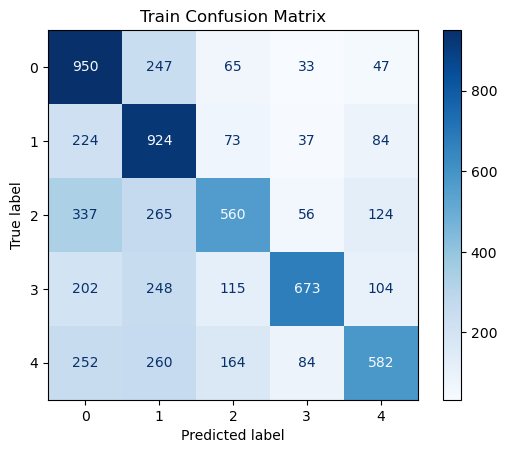

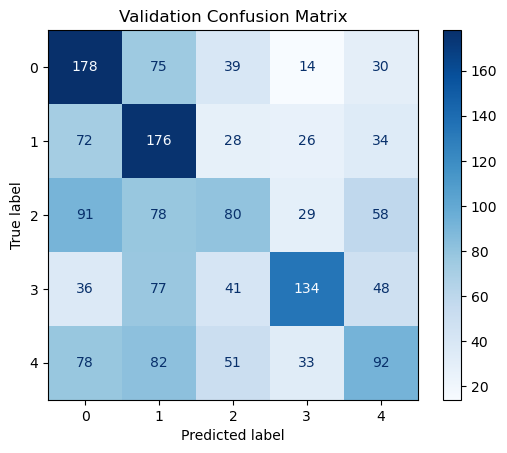

In [130]:
# Confusion Matrix for Train
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()
 
# Confusion Matrix for Validation

cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [131]:

num_classes = len(np.unique(y_train_true))
y_train_true_bin = label_binarize(y_train_true, classes=range(num_classes))
y_val_true_bin = label_binarize(y_val_true, classes=range(num_classes))
train_auc = roc_auc_score(y_train_true_bin, y_train_probs, average="macro", multi_class='ovr')
val_auc = roc_auc_score(y_val_true_bin, y_val_probs, average="macro", multi_class='ovr')
print(f"✅ Train AUC (macro): {train_auc:.4f}")
print(f"✅ Validation AUC (macro): {val_auc:.4f}")

 

✅ Train AUC (macro): 0.8430
✅ Validation AUC (macro): 0.7022


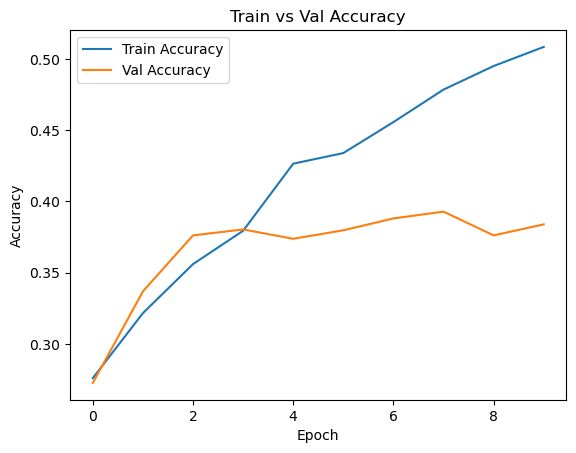

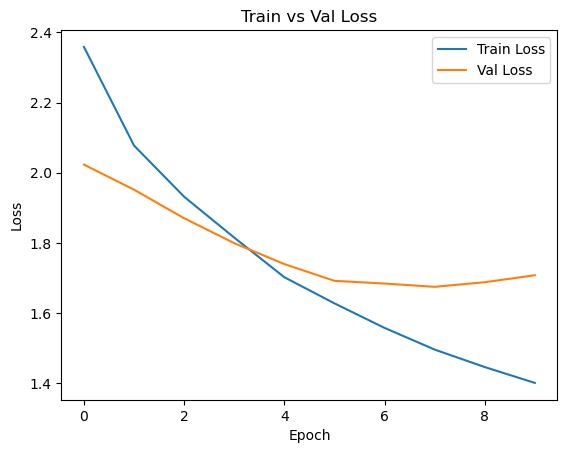

In [175]:
#8. Overfitting Plot

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.show()

## Fine-Tuning (Unfreeze Top Layers)

In [43]:
# Unfreeze top layers for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [45]:
# Recompile with low LR
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8, verbose=1)
checkpoint = ModelCheckpoint('best_effnet_model_finetuned.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [167]:
# Fine-tune
start_time = time.time()

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)

end_time = time.time()
print(f"Fine-tuning completed in {end_time - start_time:.2f} seconds")


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 801s 5s/step - accuracy: 0.5025 - loss: 1.4330 - val_accuracy: 0.3899 - val_loss: 1.6964 - learning_rate: 1.0000e-06
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.5154 - loss: 1.3973 - val_accuracy: 0.4054 - val_loss: 1.6787 - learning_rate: 1.0000e-06
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.5069 - loss: 1.4124 - val_accuracy: 0.3970 - val_loss: 1.6947 - learning_rate: 1.0000e-06
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.5244 - loss: 1.3876 - val_accuracy: 0.4012 - val_loss: 1.6884 - learning_rate: 1.0000e-06
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5235 - loss: 1.3771
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
105/105 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.5235 - loss: 1.3771 - val_accuracy: 0.3970 - val_loss: 1.7035 - learning_rate: 1.0000e-06
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 

In [168]:
# Get loss and accuracy for training set
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"✅ Train Accuracy: {train_acc:.4f}")

# Get loss and accuracy for validation set
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"✅ Validation Accuracy: {val_acc:.4f}")

105/105 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.5588 - loss: 1.3243
✅ Train Accuracy: 0.5568
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4238 - loss: 1.6514
✅ Validation Accuracy: 0.4054


In [169]:
y_train_probs = model.predict(train_gen)
y_val_probs = model.predict(val_gen)

y_train_pred = np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

y_train_true = y_train_bal
y_val_true = y_val_bal

105/105 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


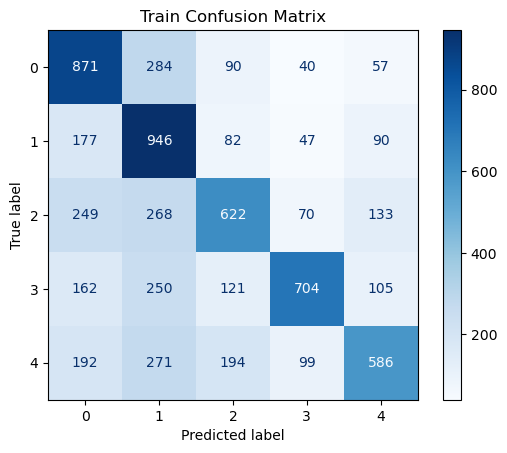

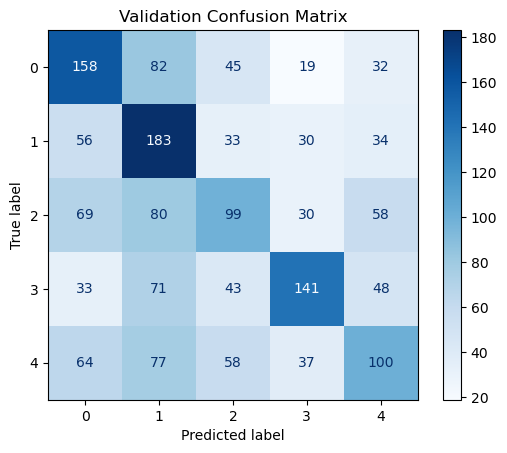

In [170]:
# Confusion Matrix for Train
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()
 
# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

In [171]:
num_classes = len(np.unique(y_train_true))
y_train_true_bin = label_binarize(y_train_true, classes=range(num_classes))
y_val_true_bin = label_binarize(y_val_true, classes=range(num_classes))
train_auc = roc_auc_score(y_train_true_bin, y_train_probs, average="macro", multi_class='ovr')
val_auc = roc_auc_score(y_val_true_bin, y_val_probs, average="macro", multi_class='ovr')
print(f"✅ Train AUC (macro): {train_auc:.4f}")
print(f"✅ Validation AUC (macro): {val_auc:.4f}") 

✅ Train AUC (macro): 0.8456
✅ Validation AUC (macro): 0.7052


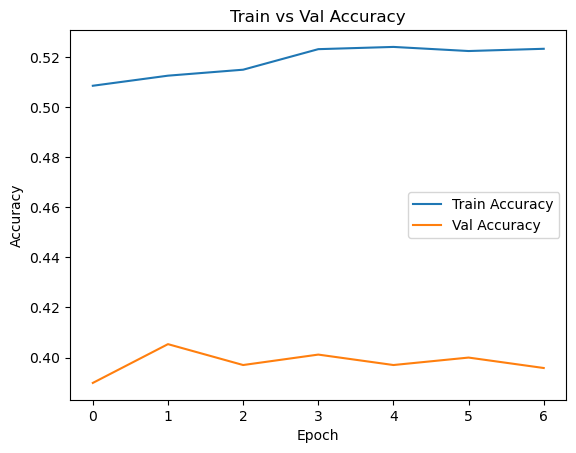

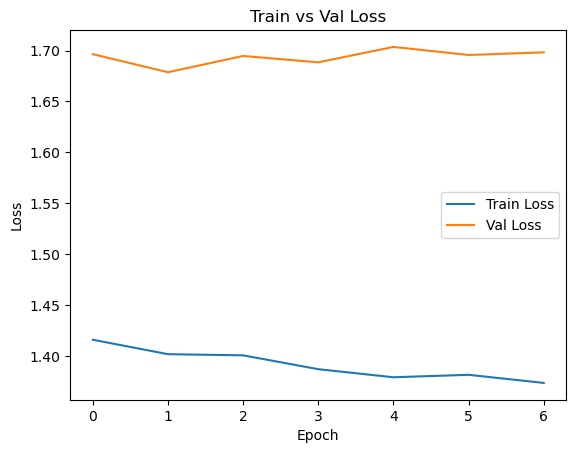

In [177]:
# Overfitting Plot

plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()
plt.show()

plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.show()